<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW6/CH_HW6_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="red"> FBB very good as always - well done!</font>

In [ ]:
!pip install ruptures

import numpy as np
import pandas as pd
import pylab as plt
%pylab inline

from ruptures.detection.pelt import Pelt
from ruptures.show.display import display
from ruptures.detection.dynp import Dynp
from ruptures.detection.binseg import Binseg

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Create Synthetic Data

Using numpy we create two stationary time series with different means, concatenate them, and detect the point of change using the mean.

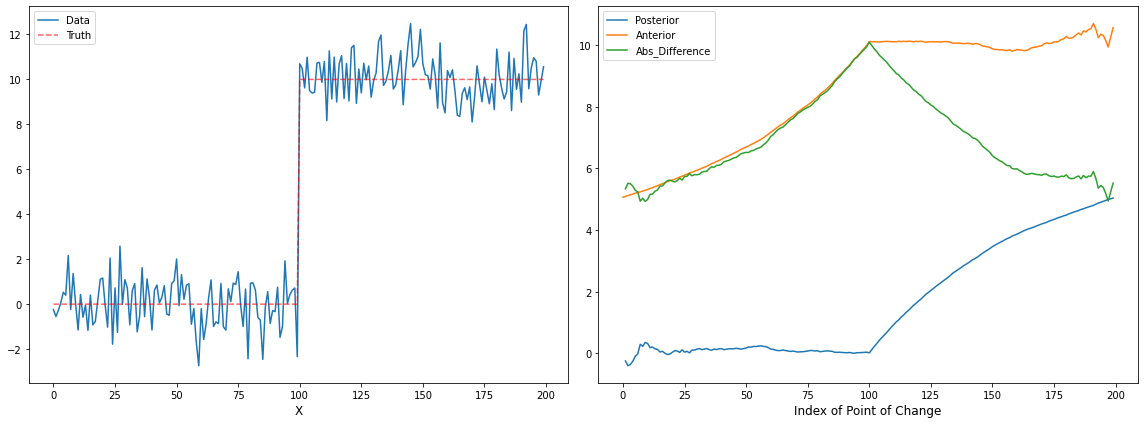

In [ ]:
#Create time series with means mu1, mu2 and std = 1

mu1, mu2 = 0, 10 
ts1 = np.random.normal(mu1, 1, 100) #100 samples
ts2 = np.random.normal(mu2, 1, 100)
ym = np.concatenate([ts1, ts2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(ym)
ax1.plot(range(0,ym.shape[0]), [mu1]*100 + [mu2]*100, 'r', ls='--', alpha=0.6)
ax1.legend(['Data', 'Truth'])
ax1.set_xlabel('X', fontsize=12);

#Examine posterior means vs. anterior means for sliding 'i'
post, ant = np.zeros(ym.shape[0]), np.zeros(ym.shape[0])

for i in range(0, ym.shape[0]): # Calculate anterior and posterior mean
  post[i] = ym[:i].mean()       # for sliding 'i' 
  ant[i] = ym[i:].mean()

ax2.plot(post)
ax2.plot(ant)
ax2.plot(abs(post-ant))
ax2.legend(['Posterior', 'Anterior', 'Abs_Difference'])
ax2.set_xlabel('Index of Point of Change', fontsize=12);

fig.tight_layout();

**Figure 1:** **[Left]** Plot of synthetic data. X < 100 are drawn from N(0,1), X >= 100 are drawn from N(10,1). Mean of both distributions are shown in red. A clear point of change occurs around X = 100. **[Right]** Plot of posterior(blue) and anterior(orange) means for a rolling window over synthetic data. Absolute difference between these two vectors is shown in green. Note that their difference is maximal at our point of change: X = 100. Y-axes are unitless.

<font color="red"> FBB very nice</font>

# Single Point of Change, Difference of Means

*Note:* Here we take the absolute value of the difference between the posterior and anterior means, therefore we maximize over this difference. This was done to make the function robust on time series where the mean after the point of change may not necessarily be higher than it was prior to it.

In [ ]:
def post_ant(arr, sigma=False):
  '''
  Consumes array and returns arrays containing posterior and anterior
  means for i ranging the length of the array.

  If sigma == True, then anterior and posterior variance is returned
  '''
  post, ant = np.zeros(arr.shape[0]), np.zeros(arr.shape[0])

  if sigma == False:
    for i in range(0, arr.shape[0]): # Calculate anterior and posterior mean
      post[i] = arr[:i].mean()       # for sliding 'i' 
      ant[i] = arr[i:].mean()
  
  else:
    for i in range(0, arr.shape[0]):
      post[i] = arr[:i].var()       
      ant[i] = arr[i:].var()

  return post, ant

def maxdiff(arr, sigma=False):
  '''
  Consumes an array, and finds the point of change in the array by maximizing
  over difference of means.

  If sigma == True, then finds point of change using difference of
  '''
  post, ant = post_ant(arr)  

  poc_index = np.nanargmax(abs((post - ant)))
  before = arr[:poc_index].mean()
  after = arr[poc_index:].mean()

  print(f'Point of Change Detected at X = {poc_index}\n')
  print(f'Mean Before: {before}')
  print(f'Mean After: {after}\n')
  return poc_index, before, after

Point of Change Detected at X = 100

Mean Before: 0.018963338637750078
Mean After: 10.114205701619147



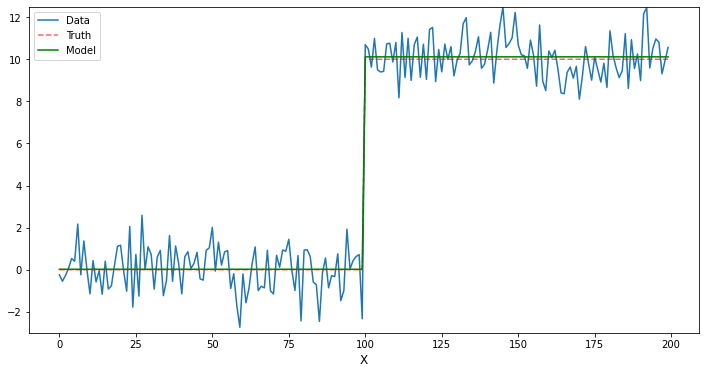

In [ ]:
#Apply to synthetic data
poc_index, before, after = maxdiff(ym)

#Plot to confirm
plt.figure(figsize=(12,6))
plt.plot(ym)
plt.plot(range(0,ym.shape[0]), [mu1]*100 + [mu2]*100, 'r', ls='--', alpha=0.6)
plt.plot(range(0,200), [before]*poc_index + [after]*(ym.shape[0] - poc_index),
         c = 'g')
plt.ylim(-3, 12.5)
plt.legend(['Data', 'Truth', 'Model'])
plt.xlabel('X', fontsize=12);

**Figure 2:** Plot of our synthetic data (Blue) overlayed with the mean ground-truth (Red) and our model mean estimated using maxdiff (Green).

These results confirm our function works as X < 100 are drawn from N(0,1). Hence, the logical point of change is at X = 100 since X >= 100 are drawn from N(10, 1).

# Single Point of Change, Mean Squared Error

In [ ]:
def poc_mse(arr):
  '''
  Consumes array and returns single point of change determined
  by minimizing mean squared error.
  '''
  mse = np.zeros(arr.shape[0]) #allocate array
  post, ant = post_ant(arr)

  for i in range(0, arr.shape[0]):
    mse[i] = np.sum((arr[:i] - post[i])**2) + np.sum((arr[i:] - ant[i])**2) #MSE

  poc_index = np.nanargmin(mse) #determine i that minimizes MSE
  before = arr[:poc_index].mean() 
  after = arr[poc_index:].mean()

  print(f'Point of Change Detected at X = {poc_index}\n')
  print(f'Mean Before: {before}')
  print(f'Mean After: {after}\n')

  return poc_index, before, after, mse

Point of Change Detected at X = 100

Mean Before: 0.018963338637750078
Mean After: 10.114205701619147



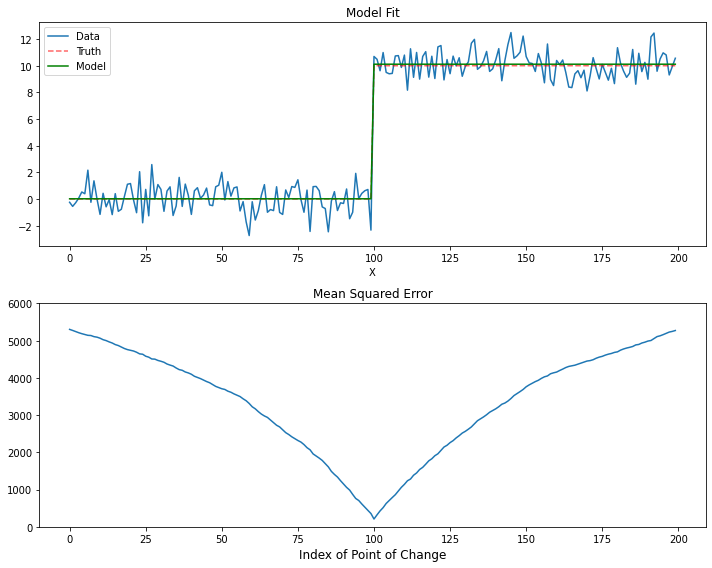

In [ ]:
#Plot results
poc_index, before, after, mse = poc_mse(ym)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(10,8))
xlim = ym.shape[0]

ax1.set_title('Model Fit')
ax1.plot(ym)
ax1.plot(range(0,xlim), [mu1]*100 + [mu2]*100, 'r', ls='--', alpha=0.6)
ax1.plot(range(0,xlim), [before]*poc_index + [after]*(xlim-poc_index), 'g')
ax1.legend(['Data', 'Truth', 'Model'])
ax1.set_xlabel('X')

ax2.set_title('Mean Squared Error')
ax2.plot(mse)
ax2.set_ylim(0, 6000)
ax2.set_xlabel('Index of Point of Change', fontsize=12);

fig.tight_layout();

**Figure 3:** Plot of synthetic data overlayed with ground truth value of means, as well as model means obtained by minimizing mean squared error shown on the Top. Mean squared error for a point of change at every sample location shown on Bottom.

Again, we can confirm our function is working here through the results of the above figure. I find this method much more intuitive than taking a difference of the anterior and posterior means.

<font color="red"> FBB very good</font>

# Single Point of Change: Difference of Variance

Calculation of variance can be unstable near the begining or end of the time series so we use a random seed to force an example which works as expected. To address this issue we could restrict the search space to a subset of candidate points ex: [15, 185] instead of [0, 200] but that seems beyond the scope here.

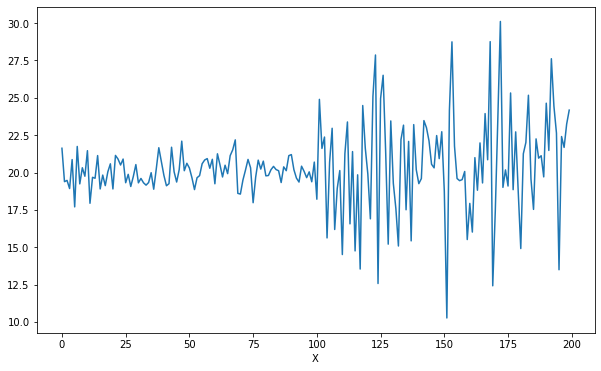

In [ ]:
#Generate data with same mean but different variance
np.random.seed(1) #Set seed
mu = 20
ys = np.concatenate([np.random.normal(mu,1,100), np.random.normal(mu,4,100)])
plt.figure(figsize=(10,6))
plt.plot(ys)
plt.xlabel('X');


**Figure 4:** Plot of simulated data. X < 100 are drawn from N(20, 1), X >= 100 are drawn from N(20,2)

In [ ]:
#Redefine maxdiff to select POC by maximizing difference of Variance
def maxdiff(arr, sigma=False):
  '''
  Consumes an array, and finds the point of change in the array by maximizing
  over difference of means.

  If sigma == True, then finds point of change using difference of variance.
  '''
  criteria = 'Variance' if sigma else 'Mean'
  post, ant = post_ant(arr, sigma)  
  poc_index = np.nanargmax(abs((post - ant)))
  
  before = arr[:poc_index].var() if sigma else arr[:poc_index].mean()
  after = arr[poc_index:].var() if sigma else arr[poc_index:].mean()

  print(f'Point of Change Detected at X = {poc_index}\n')
  print(f'{criteria} Before: {before}')
  print(f'{criteria} After: {after}\n')
  return poc_index, before, after

Point of Change Detected at X = 101

Variance Before: 0.8092619737091691
Variance After: 13.979457054548762



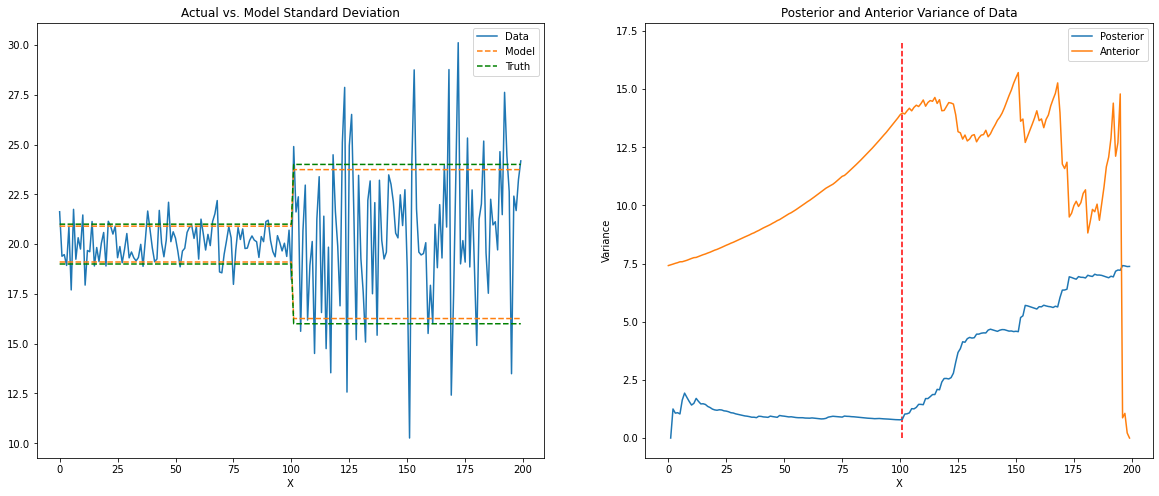

In [ ]:
#Plot point of Change using variance (maxdiff)
poc_index, before, after = maxdiff(ys, sigma=True)
post, ant = post_ant(ys, sigma=True)
before = np.sqrt(before)
after = np.sqrt(after)
model = np.concatenate([[mu+before]*poc_index, [mu+after]*(ys.shape[0]-poc_index)])
gt = np.concatenate([[mu+1]*poc_index, [mu+4]*(ys.shape[0]-poc_index)])

#Plot model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.plot(ys, label='Data')
ax1.plot(model, color='tab:orange', ls='--', label='Model')
ax1.plot(model*-1 + mu*2, color='tab:orange', ls='--')
ax1.plot(gt, color='green', ls='--')
ax1.plot(gt*-1 + mu*2, color='green', ls='--', label='Truth')
ax1.legend()
ax1.set_xlabel('X')
ax1.set_title('Actual vs. Model Standard Deviation')

ax2.plot(post)
ax2.plot(ant)
ax2.vlines(poc_index,0,17, color='red', ls='--')
ax2.set_xlabel('X')
ax2.set_ylabel('Variance')
ax2.legend(['Posterior','Anterior'])
ax2.set_title('Posterior and Anterior Variance of Data');

**Figure 5:** Plot of simulated data with model and actual standard deviations shown on the Left. One standard deviation for model and ground truth are rendered +/- the actual data mean of 20. Point of change using difference of variance was determined to be at X=101. On the right, anterior vs. posterior variance is shown for all X, and the location of the maximal difference between the two (i.e. point of change) is indicated by the red dashed line.

Although the data we simulated for POC using mean and variance were different, the distribution cutoffs were identical so we can justify a comparison here.
Whereas our POC using mean was located at 100, using variance we obtain a POC at sample 101.  The difference between results of the two methods is purely semantic - really they are both pointing out that the distributions from which the data is drawn before X=100 and after X=101 are different.



<font color="red"> FBB very goof work and very nice additional plots that help you make a good case for yout interpretation</font>

# POC Detection Using Rupture

Point of Change Detected at X = 100

Mean Before: 0.018963338637750078
Mean After: 10.114205701619147



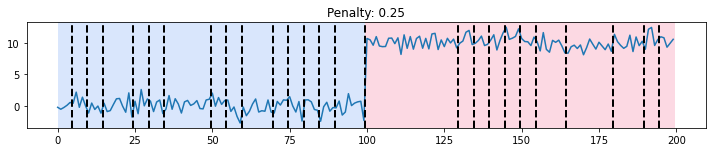

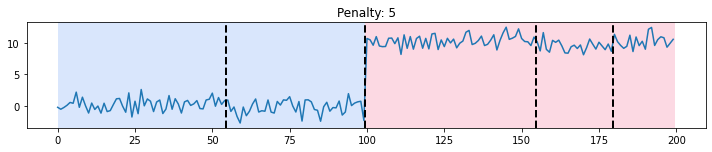

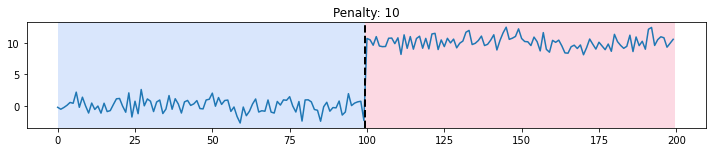

In [ ]:
#Detect POC of ym
mean = Pelt(model='l2').fit(ym)
pen_list = [0.25, 5, 10]
poc = maxdiff(ym)[0]

for pen in pen_list:
  fig, ax = display(ym, true_chg_pts=[poc,200], computed_chg_pts = mean.predict(pen),
                    computed_chg_pts_linewidth=2)
  ax[0].set_title(f'Penalty: {pen}')

**Figure 6:** Change points of simulated data with different means using PELT with L2 cost function for varying penalty terms. Plots are titled with the penalty term used in their changepoint detection. Shaded regions denote segments of homogenious mean detected using maxdiff.

To probe the best choice of penalty term we iterated over various choices and saw which gave us the best fit. AIC and BIC are commonly used starting points for the penalty term but I couldn't find a great resource on how to calculate them here. Here we require a penalty term of 10 in order to recieve a POC from Pelt in line with what we detected using maxdiff and poc_mse. 

<font color="red"> FBB very good</font>

Point of Change Detected at X = 101

Variance Before: 0.8092619737091691
Variance After: 13.979457054548762



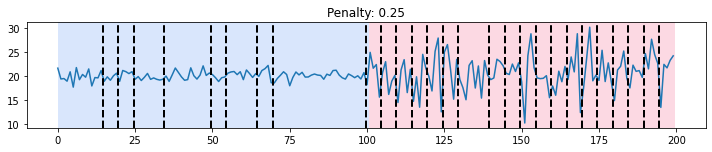

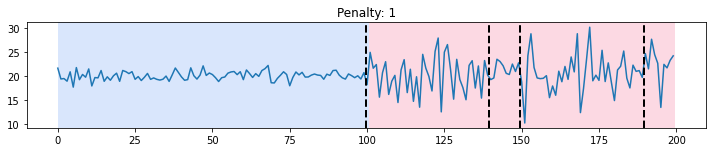

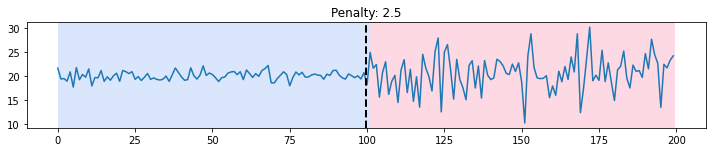

In [ ]:
#Detect POC of ys
mean = Pelt(model='rbf').fit(ys)
pen_list = [0.25, 1, 2.5]
poc = maxdiff(ys, sigma=True)[0]

for pen in pen_list:
  fig, ax = display(ys, true_chg_pts=[poc,200], computed_chg_pts = mean.predict(pen),
                    computed_chg_pts_linewidth=2)
  ax[0].set_title(f'Penalty: {pen}')

**Figure 7:** Change points of simulated data with different variance using PELT with rbf cost function for varying penalty terms. Plots are titled with the penalty term used in their changepoint detection. Shaded regions denote segments of homogenious mean detected using maxdiff.

Again, here we iterate through multiple different choices of penalty terms until we find one which agrees with the ground truth. Interestingly, L1 and L2 cost functions are unable to detect the point of change at X=100. RBF is able to do this, hence why it was chosen.

<font color="red"> FBB very good</font>

# LANL Earthquake Detection

In [ ]:
#import Earthquake data
eq = pd.read_csv('http://fbb.space/mltsa/LALNeq.csv', index_col=0)
eq.describe()

,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06
mean,4.616407e+00,8.852012e-01
std,2.614006e+01,3.374432e-01
min,-4.621000e+03,3.008971e-01
25%,2.000000e+00,5.934956e-01
50%,5.000000e+00,8.849986e-01
75%,7.000000e+00,1.177597e+00
max,3.252000e+03,1.469100e+00


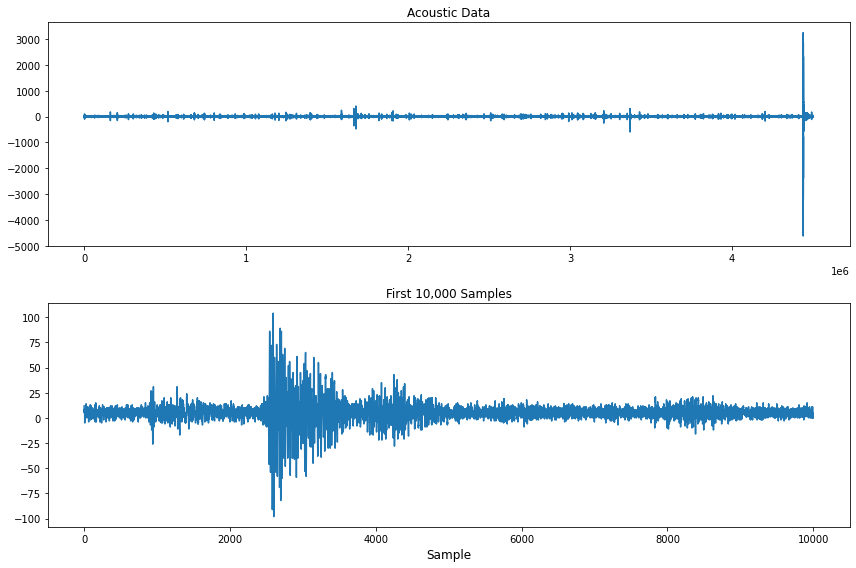

In [ ]:
#Plot earthquake data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
ax1.plot(eq['acoustic_data'])
ax1.set_title('Acoustic Data')
ax1.set_xlabel('')
ax2.plot(eq['acoustic_data'][:10000])
ax2.set_title('First 10,000 Samples')
ax2.set_xlabel('Sample', fontsize=12)
fig.tight_layout();

**Figure 8:** Visualization of LALN earthquake data. **[Top]** Visualization of full dataset, some event occurs around sample 450,000 (or perhaps measurement error). **[Bottom]** Visualization of first 10,000 samples of the dataset. This is the data that we will be doing POC detection on.

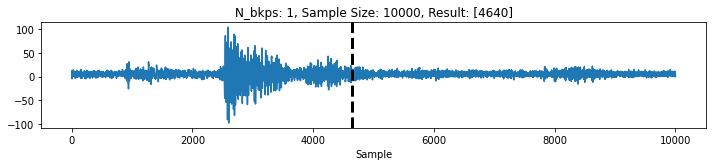

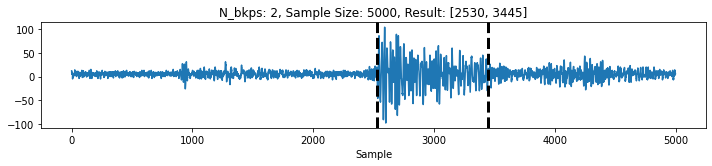

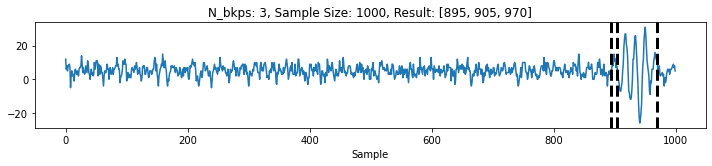

In [ ]:
#Use Dynp to calculate changepoints for k=1,2,3 over first 10000, 5000, and 1000 samples
func_dict = {1: 10000, 2: 5000, 3: 1000}

for k, cutoff in func_dict.items():
  #Extract training data and make predictions
  ts = eq['acoustic_data'].values[:cutoff]
  model = Dynp(model='normal').fit(ts)
  result = model.predict(n_bkps=k)

  #Plot
  fig, ax = display(ts, [], result)
  ax[0].set_title(f'N_bkps: {k}, Sample Size: {cutoff}, Result: {result[:-1]}')
  ax[0].set_xlabel('Sample')

**Figure 9:** Model POC predictions, using optimal dynamic programming method with 'normal' cost function, finding 1,2, and 3 POC's over 10000, 5000, and 1000 samples respectively. Number of breakpoints and sample size denoted in the title of each plot - as well as the location of the breakpoints.

Dynamic Programming Method has a worst-case runtime of O(CkN^2) where C is the complexity of the cost function used, k is the number of breakpoints to detect and N is the size of the input data. Could not find any documentation which included computational complexity of normal cost function - but it definitely out performs L1 and L2 cost functions in terms of predictions (possibly because it considers covariance?) and is on a similar order of complexity (O(N)) based on runtime. 

<font color="red"> FBB very good. Not sure that the covariance argument holds. Its prob ably the assumption of Gaussianity that simplifies the calculation of the covariance - that may be what increases efficiency </font>

Predictions in the k=2 and k=3 case seem to be reasonable, albeit over-determined in the case of k=3. For k=1, it seems the model is splitting the time-series into two segments: one with high variance and one with low variance. Although I wouldn't guess this placement on my own - it does accomplish what we asked it to and we know that this is the optimal solution given our cost function.

<font color="red"> FBBagain careful with vague statements as "seems reasonable" - if I feel the need of such a statment I would rather say something like from visual inspectionm the model is consistent with our expectations</font>


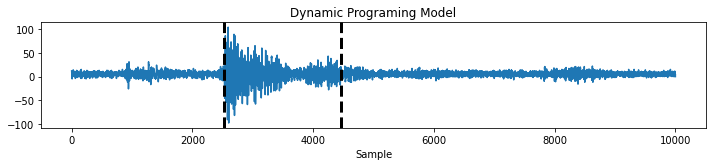

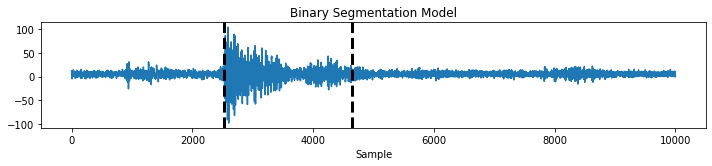

In [ ]:
#Evaluate Dynp and Binseg for k=2 (yielding 3 partitioned segments)
cutoff = 10000
ts = eq['acoustic_data'].values[:cutoff]

dynp = Dynp(model='normal').fit(ts)
fig, ax = display(ts, [], dynp.predict(n_bkps=2))
ax[0].set_title('Dynamic Programing Model')
ax[0].set_xlabel('Sample')

binseg = Binseg(model='normal').fit(ts)
fig, ax = display(ts, [], binseg.predict(n_bkps=2))
ax[0].set_title('Binary Segmentation Model')
ax[0].set_xlabel('Sample');

**Figure 10:** Comparison of POC detection for 2 breakpoints using Dynamic Programming and Binary Segmentation Search methods - both using normal cost function.

Normal cost function was chosen again for both models due to superior performance over L1 and L2 and complexity advantage over rbf which was used previously. Binseg is and approximation of Dynp so the same cost function was used to compare the approximation to the optimal solution.

Binary Segmentation has a runtime of O(NlogN). The tradeoff here is that the output of Binseg is an approximation rather than an optimal solution. We can see that there are slight differences in the predictions of the breakpoint after Sample=4000. However, both models make highly similar predictions for our first breakpoint - and the differences that do exist for the second breakpoint are minor. I'm much in favor for the approximation in this case given that it is significantly faster and altough it is not 'optimal' in the same way as Dynamic Programming - achieving an optimal solution over an objective function is not the same thing as finding the ground truth. 

<font color="red"> FBB very good</font>